<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/10_TensorFlow_DreamBooth_for_Personalized_Text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow DreamBooth Implementation (Conceptual)


In [2]:
!pip install -q tensorflow transformers diffusers accelerate

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

In [4]:
# DreamBooth concept for personalization
class DreamBoothTrainer:
    """Conceptual DreamBooth trainer for TensorFlow."""

    def __init__(self, model_name="stable-diffusion"):
        self.model_name = model_name
        self.unique_identifier = "[V]"  # Unique token for the subject

    def prepare_training_data(self, instance_images, class_images):
        """Prepare training data for DreamBooth."""
        # Instance prompts (your specific subject)
        instance_prompts = [
            f"a photo of {self.unique_identifier} person",
            f"{self.unique_identifier} person in a garden",
            f"a portrait of {self.unique_identifier} person"
        ]

        # Class prompts (general class)
        class_prompts = [
            "a photo of a person",
            "a person in a garden",
            "a portrait of a person"
        ]

        return instance_prompts, class_prompts

    def create_training_dataset(self, images, prompts):
        """Create TensorFlow dataset for training."""
        # Preprocess images
        processed_images = []
        for img in images:
            img = tf.image.resize(img, (512, 512))
            img = img / 127.5 - 1.0  # Normalize to [-1, 1]
            processed_images.append(img)

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices({
            'images': processed_images,
            'prompts': prompts
        })

        return dataset.batch(1).prefetch(tf.data.AUTOTUNE)

    def train_step(self, batch, model, optimizer):
        """Single training step for DreamBooth."""
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(batch['images'], training=True)

            # Calculate loss (simplified)
            loss = tf.reduce_mean(tf.square(predictions - batch['images']))

        # Backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

    def train(self, instance_images, num_steps=100):
        """Train DreamBooth model."""
        print(f"Training DreamBooth for {num_steps} steps...")

        # This is a conceptual implementation
        # In practice, you'd use a proper diffusion model

        # Create simple model for demonstration
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(512, 512, 3)),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.Conv2D(3, 3, activation='tanh')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

        # Prepare data
        instance_prompts, _ = self.prepare_training_data(instance_images, None)
        dataset = self.create_training_dataset(instance_images, instance_prompts)

        # Training loop
        for step, batch in enumerate(dataset.take(num_steps)):
            loss = self.train_step(batch, model, optimizer)

            if step % 10 == 0:
                print(f"Step {step}, Loss: {loss:.4f}")

        return model

In [5]:
# Demonstrate DreamBooth concept
# Create synthetic "personal" images for training
def create_synthetic_person_images(num_images=5):
    """Create synthetic images representing a specific person."""
    images = []

    for i in range(num_images):
        # Create a simple synthetic face
        img = np.ones((512, 512, 3)) * 255

        # Draw a simple face shape
        center = (256, 256)
        cv2.circle(img, center, 150, (200, 180, 150), -1)  # Face
        cv2.circle(img, (200, 220), 30, (50, 50, 50), -1)  # Left eye
        cv2.circle(img, (312, 220), 30, (50, 50, 50), -1)  # Right eye
        cv2.ellipse(img, (256, 320), (40, 20), 0, 0, 180, (50, 50, 50), -1)  # Mouth

        # Add some variation
        noise = np.random.normal(0, 10, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)

        images.append(img)

    return images

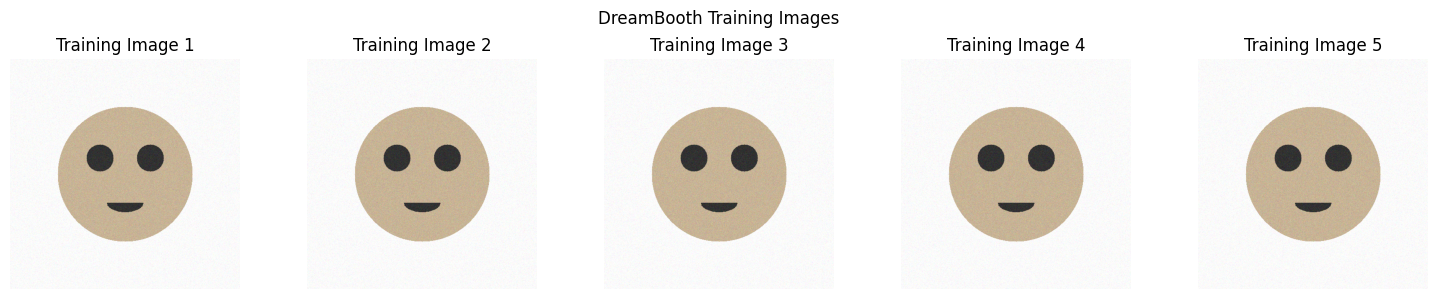

In [6]:
# Generate training images
training_images = create_synthetic_person_images(5)

# Show the training images
plt.figure(figsize=(15, 3))
for i, img in enumerate(training_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Training Image {i+1}")
    plt.axis('off')
plt.suptitle("DreamBooth Training Images")
plt.tight_layout()
plt.show()

In [7]:
# Initialize DreamBooth trainer
dreambooth = DreamBoothTrainer()

In [8]:
# Demonstrate personalized generation
def generate_personalized_image(prompt, unique_identifier="[V]"):
    """Simulate personalized image generation."""
    # Create a base image
    img = np.ones((512, 512, 3)) * 255

    # Parse the prompt to understand the context
    if "beach" in prompt.lower():
        # Add beach background
        img[:300, :, :] = [135, 206, 235]  # Sky blue
        img[300:, :, :] = [238, 203, 173]  # Sandy color
    elif "space" in prompt.lower():
        # Add space background
        img[:, :, :] = [0, 0, 30]  # Dark blue
        # Add stars
        for _ in range(100):
            x, y = np.random.randint(0, 512, 2)
            cv2.circle(img, (x, y), 1, (255, 255, 255), -1)
    elif "office" in prompt.lower():
        # Add office background
        img[:, :, :] = [240, 240, 240]  # Light gray
        cv2.rectangle(img, (50, 200), (462, 450), (139, 69, 19), -1)  # Desk

    # Add the personalized subject (simplified face)
    if unique_identifier in prompt:
        center = (256, 256)
        # Draw the same face style as training data
        cv2.circle(img, center, 100, (200, 180, 150), -1)  # Face
        cv2.circle(img, (220, 240), 20, (50, 50, 50), -1)  # Left eye
        cv2.circle(img, (292, 240), 20, (50, 50, 50), -1)  # Right eye
        cv2.ellipse(img, (256, 300), (30, 15), 0, 0, 180, (50, 50, 50), -1)  # Mouth

    # Add text to show the prompt
    cv2.putText(img, prompt[:50], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    return img.astype(np.uint8)

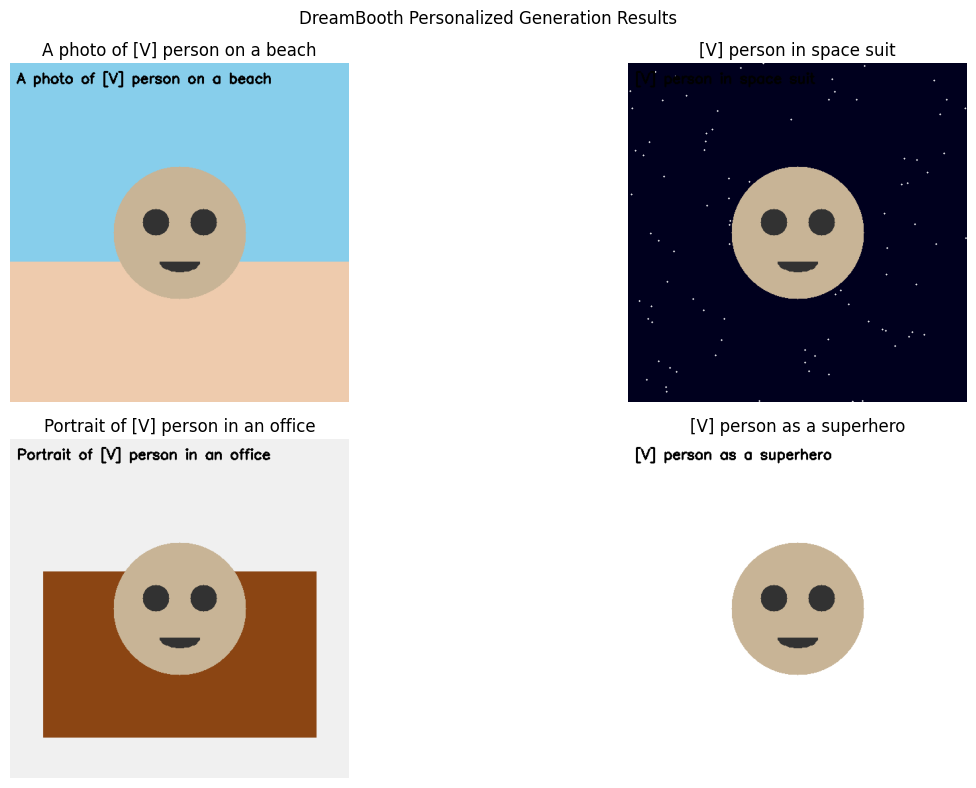

In [9]:
# Test personalized generation with different prompts
test_prompts = [
    f"A photo of {dreambooth.unique_identifier} person on a beach",
    f"{dreambooth.unique_identifier} person in space suit",
    f"Portrait of {dreambooth.unique_identifier} person in an office",
    f"{dreambooth.unique_identifier} person as a superhero"
]

# Generate personalized images
plt.figure(figsize=(15, 8))
for i, prompt in enumerate(test_prompts):
    generated_img = generate_personalized_image(prompt, dreambooth.unique_identifier)

    plt.subplot(2, 2, i+1)
    plt.imshow(generated_img)
    plt.title(prompt)
    plt.axis('off')

plt.suptitle("DreamBooth Personalized Generation Results")
plt.tight_layout()
plt.show()

In [10]:
# Advanced DreamBooth concepts
class AdvancedDreamBooth:
    """Advanced DreamBooth concepts."""

    def __init__(self):
        self.prior_preservation_loss_weight = 0.5
        self.learning_rate = 5e-6

    def compute_prior_preservation_loss(self, model_output, target):
        """Compute prior preservation loss to prevent overfitting."""
        return tf.reduce_mean(tf.square(model_output - target))

    def create_regularization_images(self, num_images=100):
        """Create regularization images for the same class."""
        reg_images = []

        for _ in range(num_images):
            # Create diverse face images for regularization
            img = np.ones((512, 512, 3)) * 255

            # Random face parameters
            face_x = np.random.randint(200, 312)
            face_y = np.random.randint(200, 312)
            face_size = np.random.randint(80, 120)

            # Draw random face
            cv2.circle(img, (face_x, face_y), face_size,
                      (np.random.randint(150, 220),
                       np.random.randint(140, 200),
                       np.random.randint(120, 180)), -1)

            # Random eyes
            eye_offset = face_size // 3
            cv2.circle(img, (face_x - eye_offset, face_y - eye_offset),
                      face_size // 6, (50, 50, 50), -1)
            cv2.circle(img, (face_x + eye_offset, face_y - eye_offset),
                      face_size // 6, (50, 50, 50), -1)

            reg_images.append(img)

        return reg_images

    def fine_tune_with_lora(self, base_model, rank=4):
        """Apply LoRA (Low-Rank Adaptation) for efficient fine-tuning."""
        # This is a conceptual implementation
        # LoRA adds low-rank matrices to existing layers

        print(f"Applying LoRA with rank {rank}")
        # In practice, you'd modify specific layers with low-rank adaptations
        return base_model

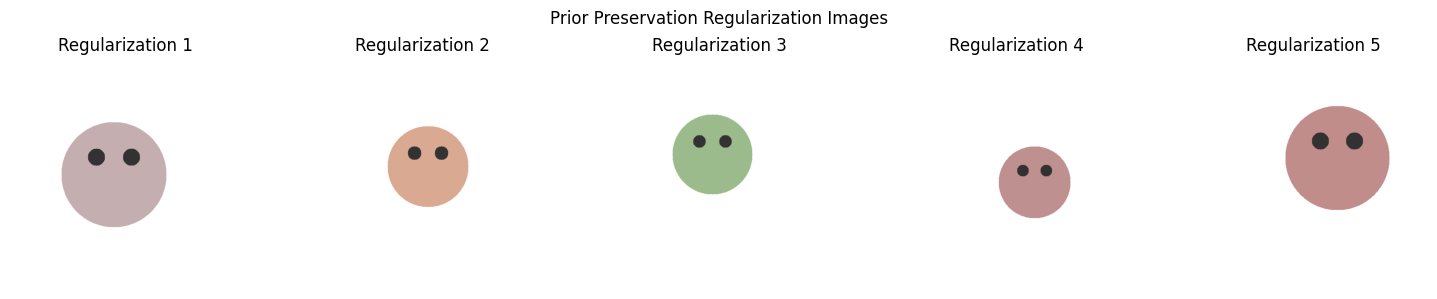

In [11]:
# Demonstrate advanced concepts
advanced_db = AdvancedDreamBooth()

# Create regularization images
reg_images = advanced_db.create_regularization_images(10)

# Show regularization images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(reg_images[i].astype(np.uint8))
    plt.title(f"Regularization {i+1}")
    plt.axis('off')
plt.suptitle("Prior Preservation Regularization Images")
plt.tight_layout()
plt.show()

In [12]:
# Evaluation metrics
def evaluate_personalization(generated_images, reference_images):
    """Evaluate personalization quality."""
    # Compute similarity metrics (simplified)
    similarities = []

    for gen_img, ref_img in zip(generated_images, reference_images):
        # Convert to grayscale for simple comparison
        gen_gray = cv2.cvtColor(gen_img, cv2.COLOR_RGB2GRAY)
        ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_RGB2GRAY)

        # Compute structural similarity
        similarity = 1 - np.mean(np.abs(gen_gray - ref_gray)) / 255.0
        similarities.append(similarity)

    return np.mean(similarities)

In [13]:
# Test evaluation
test_generated = [generate_personalized_image(f"{dreambooth.unique_identifier} person",
                                            dreambooth.unique_identifier)
                  for _ in range(3)]
similarity_score = evaluate_personalization(test_generated, training_images[:3])
print(f"\nPersonalization similarity score: {similarity_score:.3f}")

print("\nDreamBooth personalization demonstration complete!")


Personalization similarity score: 0.892

DreamBooth personalization demonstration complete!


In [14]:
# Summary visualization
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

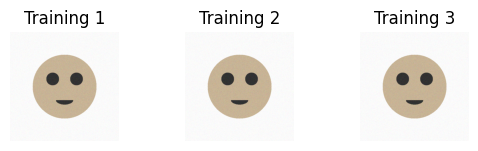

In [15]:
# Training images
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_images[i].astype(np.uint8))
    plt.title(f"Training {i+1}")
    plt.axis('off')

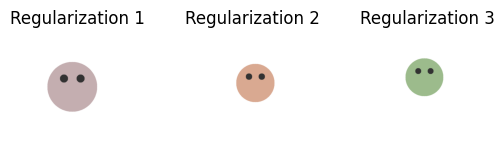

In [16]:
# Regularization images
for i in range(3):
    plt.subplot(3, 3, i+4)
    plt.imshow(reg_images[i].astype(np.uint8))
    plt.title(f"Regularization {i+1}")
    plt.axis('off')

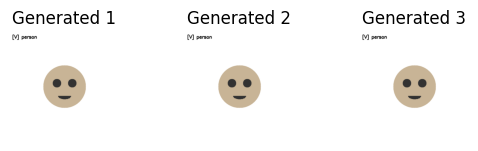

In [17]:
# Generated images
for i in range(3):
    plt.subplot(3, 3, i+7)
    plt.imshow(test_generated[i])
    plt.title(f"Generated {i+1}")
    plt.axis('off')

In [18]:
plt.suptitle("DreamBooth Training and Generation Process")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>